In [7]:
import torch
from torch import nn


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)

In [8]:
from net import GAN
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data import ConcatDataset, DataLoader

EPOCHS = 200
BATCH_SIZE = 128
LATENT_DIM = 128
SAVE_DIR = "gen_images/mnist_gan"

transform = transforms.Compose(
    [
        transforms.ToTensor(),  # (1, 28, 28)
        transforms.Normalize(mean=(0.5,), std=(0.5,)),  # [-1, 1]
        transforms.Lambda(lambda x: x.view(-1)),  # (28 * 28,)
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
dataset = ConcatDataset([train_dataset, test_dataset])

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

discriminator = Discriminator()
generator = Generator(LATENT_DIM)

d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

gan = GAN(
    discriminator,
    generator,
    d_optimizer,
    g_optimizer,
    BATCH_SIZE,
    LATENT_DIM,
    SAVE_DIR,
    dataset,
    device,
)

g_losses, d_losses = [], []

for epoch in range(EPOCHS):
    epoch_g_loss, epoch_d_loss = gan.train(epoch)
    g_losses += epoch_g_loss
    d_losses += epoch_d_loss

Epoch #200: 100%|██████████| 547/547 [00:08<00:00, 60.80batch/s, Avg Gen. Loss=1.4930, Avg Disc. Loss=0.9434]


In [10]:
torch.save(generator.state_dict(), "models/gen_gan.pt")
torch.save(discriminator.state_dict(), "models/disc_gan.pt")

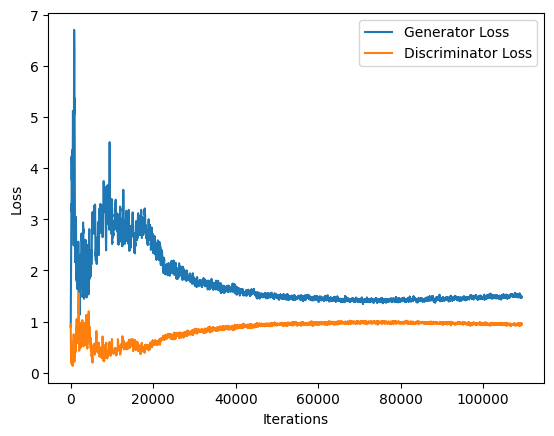

In [9]:
from net import plot_losses

window = 100

fig, ax = plot_losses(g_losses, window, label="Generator Loss")
fig, ax = plot_losses(d_losses, window, label="Discriminator Loss", ax=ax)

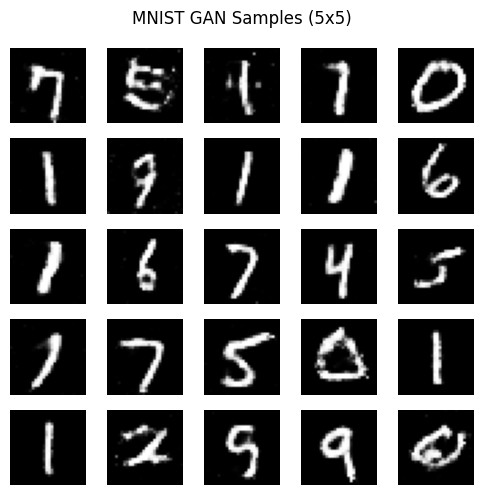

In [15]:
fig = gan.plot_samples()

In [16]:
from net import gif_from_images

gif_from_images(SAVE_DIR, SAVE_DIR, fps=20)